In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
import tensorflow as tf
import time
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from tensorflow.python.framework import ops
from ops import *
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


In [2]:
epoch = 5000 #epoch
batch_size = 32# batch_size

# image sizing
input_height = 128
input_width = 128
output_height = 128
output_width = 128

z_dim = 100       # dimension of noise-vector
c_dim = 3

# WGAN parameter
disc_iters = 2     # The number of critic iterations for one-step of generator
    
# train
learning_rate = 0.0002
beta1 = 0.5

# test
sample_num = 64  # number of generated images to be saved

# some parameters
image_dims = [input_height, input_width, c_dim]
bs = batch_size

result_dir = './cifar10_rgb_results_flower/' #result_dir
model_name = 'gan_model'

In [3]:
def plot_gen(datas, start, end):
    plt.figure(figsize=(8,8))
    for i in range(start,end):
        plt.subplot(3,(end-start)/3,i+1)
        plt.imshow(datas[i])
        #plt.imshow(datas[i].reshape((output_height,output_width)), cmap='jet', interpolation='none')
        
# def rgb2gray(rgb):
#     return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [4]:
path = './flower_images'
data=[]
for filename in os.listdir(path):
    pic = Image.open(os.path.join(path, filename)).convert("RGB")
    pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
    data.append(pix)
    if pic.size[0] != 128:
        print(filename)
        print(pic.size)
    #data = np.insert(data.shape[0]-1,data,pix)
    
data = np.array(data)
print (data.shape)

(233, 128, 128, 3)


In [5]:

num_batches = len(data) // batch_size
num_batches

7

In [6]:
type(data)
data[0].shape

(128, 128, 3)

In [7]:
data = data.reshape(data.shape[0],input_height,input_width,3)
print(data.shape)
data = data/255.


(233, 128, 128, 3)


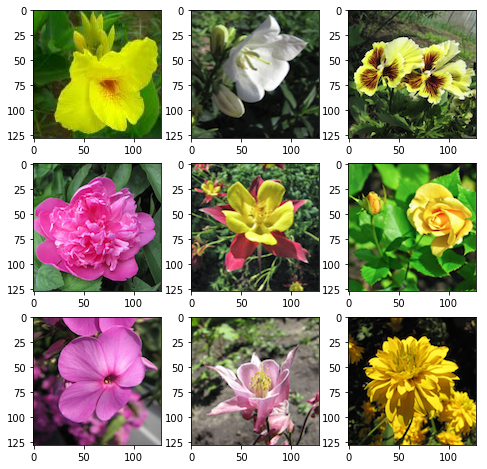

In [8]:
plot_gen(data,0,9)
imsave(data[:8 * 8, :, :, :], [8, 8],'./' + check_folder(result_dir + '/') + '/' + model_name + 'groundTruth.png')

In [9]:
data[1].shape

(128, 128, 3)

In [10]:
""" Graph Input """
# images
inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')
print(image_dims)
print(inputs.get_shape())
# noises
z = tf.placeholder(tf.float32, [bs, z_dim], name='z')
print (z.get_shape())

[128, 128, 3]
(32, 128, 128, 3)
(32, 100)


In [11]:
def discriminator( x, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    with tf.variable_scope("discriminator", reuse=reuse):

        net = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
        net = lrelu(bn(conv2d(net, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
        net = tf.reshape(net, [batch_size, -1])
        net = lrelu(bn(linear(net, 1024, scope='d_fc3'), is_training=is_training, scope='d_bn3'))
        out_logit = linear(net, 1, scope='d_fc4')
        out = tf.nn.sigmoid(out_logit)

        return out, out_logit, net

In [12]:
def generator( z, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    with tf.variable_scope("generator", reuse=reuse):
        net = tf.nn.relu(bn(linear(z, 2048, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
        net = tf.nn.relu(bn(linear(net, 512 * input_height/16 * input_width/16, scope='g_fc2'), is_training=is_training, scope='g_bn2'))
        net = tf.reshape(net, [batch_size, int(input_height/16), int(input_width/16), 512])
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, int(input_height/8), int(input_width/8), 256], 4, 4, 2, 2, name='g_dc0'), is_training=is_training,
               scope='g_bn0'))
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, int(input_height/4), int(input_width/4), 128], 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
               scope='g_bn3'))
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, int(input_height/2), int(input_width/2), 64], 4, 4, 2, 2, name='g_dc4'), is_training=is_training,
               scope='g_bn4'))
        
        out = tf.nn.sigmoid(deconv2d(net, [batch_size, input_height, input_width, 3], 4, 4, 2, 2, name='g_dc5'))
        return out

In [13]:
# for test
fake_images = generator(z, is_training=False, reuse=False)
z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim))
print (z_sample)
with tf.Session(config=tf.ConfigProto(allow_soft_placement=False)) as sess:
    tf.global_variables_initializer().run()
    samples = sess.run(fake_images, feed_dict={z: z_sample})

[[-0.3849583  -0.10943027  0.53409686 ..., -0.28128844 -0.90981319
   0.22255102]
 [-0.05630339  0.35803476 -0.30694983 ...,  0.89915899  0.95043052
   0.15910813]
 [ 0.4786945   0.5062572   0.46279952 ...,  0.28163844 -0.82046488
   0.44186997]
 ..., 
 [-0.68180034 -0.3533698  -0.67258432 ...,  0.72669075 -0.35718894
   0.06985584]
 [-0.80007216  0.31818892 -0.7671939  ..., -0.75307157  0.41437731
   0.27492921]
 [ 0.42791066 -0.8476706   0.16579784 ...,  0.79247753  0.74651375
   0.04853505]]


In [14]:
samples.shape

(32, 128, 128, 3)

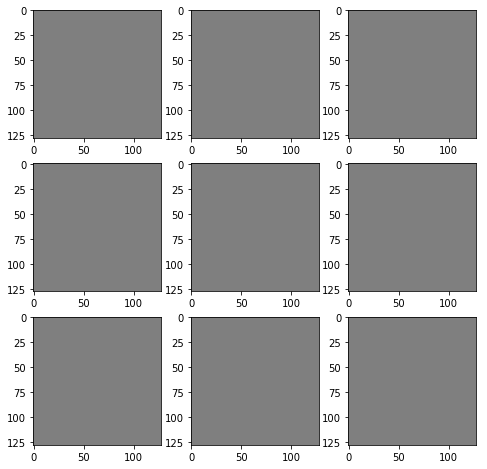

In [15]:
plot_gen(samples,0,9)

In [16]:
# output of D for real images
D_real, D_real_logits, _ = discriminator(inputs, is_training=True, reuse=False)

# output of D for fake images
G = generator(z, is_training=True, reuse=True)
D_fake, D_fake_logits, _ = discriminator(G, is_training=True, reuse=True)

# get loss for discriminator
d_loss_real = - tf.reduce_mean(D_real_logits)
d_loss_fake = tf.reduce_mean(D_fake_logits)

d_loss = d_loss_real + d_loss_fake

# get loss for generator
g_loss = - d_loss_fake

""" Summary """
d_loss_real_sum = tf.summary.scalar("d_loss_real", d_loss_real)
d_loss_fake_sum = tf.summary.scalar("d_loss_fake", d_loss_fake)
d_loss_sum = tf.summary.scalar("d_loss", d_loss)
g_loss_sum = tf.summary.scalar("g_loss", g_loss)

# final summary operations
g_sum = tf.summary.merge([d_loss_fake_sum, g_loss_sum])
d_sum = tf.summary.merge([d_loss_real_sum, d_loss_sum])

In [17]:
# divide trainable variables into a group for D and a group for G
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

In [18]:
g_vars

[<tf.Variable 'generator/g_fc1/Matrix:0' shape=(100, 2048) dtype=float32_ref>,
 <tf.Variable 'generator/g_fc1/bias:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn1/beta:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn1/gamma:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'generator/g_fc2/Matrix:0' shape=(2048, 32768) dtype=float32_ref>,
 <tf.Variable 'generator/g_fc2/bias:0' shape=(32768,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn2/beta:0' shape=(32768,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn2/gamma:0' shape=(32768,) dtype=float32_ref>,
 <tf.Variable 'generator/g_dc0/w:0' shape=(4, 4, 256, 512) dtype=float32_ref>,
 <tf.Variable 'generator/g_dc0/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn0/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'generator/g_bn0/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'generator/g_dc3/w:0' shape=(4, 4, 128, 256) dtype=float32_ref>,
 <tf.Variable 'gener

In [19]:
# optimizers
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1) \
              .minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.AdamOptimizer(learning_rate*5, beta1=beta1) \
              .minimize(g_loss, var_list=g_vars)

In [ ]:
# weight clipping this is key to Wassstein GAN
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in d_vars]

In [ ]:

with tf.Session(config=tf.ConfigProto(allow_soft_placement=False)) as sess:
        # initialize all variables
    tf.global_variables_initializer().run()

    # summary writer
    writer = tf.summary.FileWriter('./logs/' + '/' + model_name, sess.graph)
    # graph inputs for visualize training results
    sample_z = np.random.uniform(-1, 1, size=(batch_size , z_dim))
    # loop for epoch
    start_time = time.time()
    
    print(start_time)
    start_epoch = 0
    start_batch_id = 0
    counter = 1
    for temp_epoch in range(start_epoch, epoch):

        # get batch data
        for idx in range(start_batch_id, num_batches):
            batch_images = data[idx*batch_size:(idx+1)*batch_size]
            batch_z = np.random.uniform(-1, 1, [batch_size, z_dim]).astype(np.float32)
            
            # update D network
            if (counter - 1) % disc_iters == 0:
                _, _, summary_str, dd_loss = sess.run([d_optim, clip_D, d_sum, d_loss], feed_dict={inputs: batch_images, z: batch_z})
                writer.add_summary(summary_str, counter)

            # update G network
            
            _, summary_str, gg_loss = sess.run([g_optim, g_sum, g_loss], feed_dict={z: batch_z})
            writer.add_summary(summary_str, counter)

            # display training status
            
            print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                  % (temp_epoch, idx, num_batches, time.time() - start_time, dd_loss, gg_loss))
            
            # save training results for every 300 steps
            if np.mod(counter, 50) == 0:
                samples = sess.run(fake_images, feed_dict={z: sample_z})
                tot_num_samples = min(sample_num, batch_size)
                manifold_h = int(np.floor(np.sqrt(tot_num_samples)))
                manifold_w = int(np.floor(np.sqrt(tot_num_samples)))
                plot_gen(samples,0,9)
                print (manifold_h)
                print (manifold_w)
                imsave(samples[:manifold_h * manifold_w, :, :, :], [manifold_h, manifold_w],
                            './' + check_folder(result_dir + '/') + '/' + model_name + '_train_{:02d}_{:04d}.png'.format(
                                temp_epoch, idx))
            counter += 1
        # After an epoch, start_batch_id is set to zero
        # non-zero value is only for the first epoch after loading pre-trained model
        start_batch_id = 0


1511708137.9953027
Epoch: [ 0] [   0/   7] time: 1.3448, d_loss: 0.00020552, g_loss: 0.00408289
Epoch: [ 0] [   1/   7] time: 1.5525, d_loss: 0.00020552, g_loss: -0.00057808
Epoch: [ 0] [   2/   7] time: 2.0128, d_loss: 0.00027066, g_loss: 0.00304866
Epoch: [ 0] [   3/   7] time: 2.2191, d_loss: 0.00027066, g_loss: -0.00125684
Epoch: [ 0] [   4/   7] time: 2.6843, d_loss: 0.00011361, g_loss: 0.00182185
Epoch: [ 0] [   5/   7] time: 2.8939, d_loss: 0.00011361, g_loss: -0.00192886
Epoch: [ 0] [   6/   7] time: 3.3660, d_loss: 0.00004658, g_loss: 0.00068535
Epoch: [ 1] [   0/   7] time: 3.5756, d_loss: 0.00004658, g_loss: -0.00268079
Epoch: [ 1] [   1/   7] time: 4.0399, d_loss: 0.00024232, g_loss: -0.00024988
Epoch: [ 1] [   2/   7] time: 4.2452, d_loss: 0.00024232, g_loss: -0.00351806
Epoch: [ 1] [   3/   7] time: 4.7135, d_loss: 0.00021373, g_loss: -0.00092202
Epoch: [ 1] [   4/   7] time: 4.9221, d_loss: 0.00021373, g_loss: -0.00409731
Epoch: [ 1] [   5/   7] time: 5.3912, d_loss: 0.0